In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')

## Utility functions

In [2]:
def get_station_updates(city, station):
    df = pd.read_csv('challenge_data/{}/stations/{}.csv'.format(city, station))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    return df


def get_weather_updates(city):
    df = pd.read_csv('challenge_data/{}/weather.csv'.format(city))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    return df

## Pre-processing

In [3]:
def add_temporal_features(df):
    df['weekday'] = df['moment'].map(lambda m: m.weekday())
    df['hour'] = df['moment'].map(lambda m: m.hour)
    df['minute'] = df['moment'].map(lambda m: m.minute)
    return df


def add_last_update(df):
    df['last_moment'] = df['moment'].diff(1)
    last_bikes = df['bikes'][:-1]
    last_spaces = df['spaces'][:-1]
    # The first row doesn't have any previous update, dropping one row is fine
    df.drop(0, inplace=True)
    df['last_moment'] = df['last_moment'].map(lambda moment: moment.seconds)
    df['last_bikes'] = last_bikes.tolist()
    return df

    
def add_weather_updates(df, city_name):
    w_df = get_weather_updates(city)
    w_times = pd.Series(w_df['moment'].values, w_df['moment'])
    w_times.sort_values(inplace=True)
    df['moment_weather'] = w_times.reindex(df['moment'], method='nearest').values
    joined_df = pd.merge(left=df, right=w_df, left_on='moment_weather', right_on='moment', suffixes=('', '_y'))
    joined_df.drop('moment_y', 1, inplace=True)
    return joined_df


def preprocess(df):
    df = add_temporal_features(df)
    df = add_last_update(df)
    df = add_weather_updates(df, city)
    df.set_index('moment', drop=False, inplace=True)
    return df

In [4]:
def split_train_test(X, y, t0, t1, t2):
    X_train = X[(X.index >= t0) & (X.index < t1)].copy()
    X_test = X[(X.index >= t1) & (X.index <= t2)].copy()
    y_train = y[(X.index >= t0) & (X.index < t1)].copy()
    y_test = y[(X.index >= t1) & (X.index <= t2)].copy()
    return X_train, X_test, y_train, y_test

In [57]:
features = [
    'weekday',
    'hour',
    'minute',
    'last_moment',
    'last_bikes',
    'clouds',
    'humidity',
    'pressure',
    'temperature',
    'wind'
]

city = 'toulouse'
station = '00229-iut-rangueil'

df = preprocess(get_station_updates(city, station))
X = df[features]
y = df['bikes']

t2 = X.index.max()
t1 = t2 - pd.Timedelta('5 days')
t0 = t1 - pd.Timedelta('32 days')

In [58]:
from sklearn import metrics
from sklearn import preprocessing

from sklearn import ensemble
from sklearn import linear_model
from sklearn import tree

#model = ensemble.RandomForestRegressor()
#model = linear_model.LinearRegression()
model = tree.DecisionTreeRegressor()

X_train, X_test, y_train, y_test = split_train_test(X, y, t0, t1, t2)

model.fit(X_train, y_train)

predictions = []

for i in range(len(X_test)):
    # Extract the time from the current row
    t = X_test.index[i]
    # Convert the current row to a list of features
    x = X_test.iloc[i].values.reshape(1, -1)
    # Predict the number of bikes for the current row
    prediction = model.predict(x)[0]
    predictions.append(prediction)
    # Update the next rows with the latest number of bikes
    next_rows = X_test.select(lambda time: time > t)
    next_rows['last_bikes'] = [prediction] * len(next_rows)
    next_rows['last_moment'] = next_rows.index.map(lambda time: (time - t).seconds)
    X_test.update(next_rows)

predictions = pd.Series(predictions, index=y_test.index)

metrics.mean_absolute_error(y_test, predictions)

5.0974895397489535

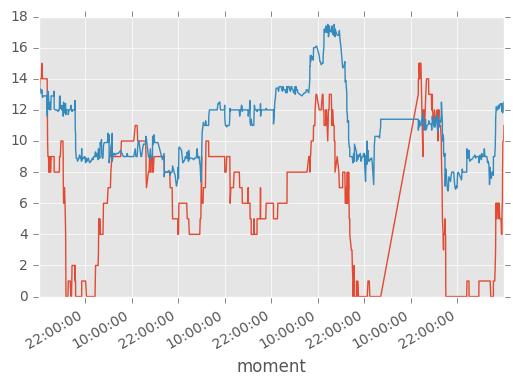

In [59]:
y_test.plot()
predictions.plot()

In [33]:
X_test.select(lambda x: x > pd.Timestamp('2016-09-30 10:06:45'))['last_bikes'] = 2